# 1. Import, Setting

## (1) Libraries

In [1]:
# Basic Library
import os
os.environ["CUDA_VISIBLE_DEVICES"]='-1'
from itertools import permutations
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import xgboost as xgb
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Dense, Add, Input
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## (2) Data

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

## (3) Variables

In [3]:
pred_dict = {}
pred_test_dict = {}

In [4]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
classes = 4 # 주어진 데이터의 class 수
num_trial = 20 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

## (4) Folder

In [5]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pkl")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pkl
Directory already existed : ../model
Directory already existed : ../submission


# 2. Modeling

## (1) LightGBM

In [6]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

### a. Hyperparameter Tuning

In [7]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": basic_seed,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.005, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((rows_train, classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [8]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-20 01:39:38,610] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-20 01:39:46,677] Trial 0 finished with value: 0.75203426124197 and parameters: {'learning_rate': 0.021854305348131316, 'reg_alpha': 0.9507143064099162, 'reg_lambda': 0.7319939418114051, 'max_depth': 7, 'num_leaves': 356, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.05808361216819946, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 0.75203426124197.


accuracy_score: 0.75203426124197


[I 2022-03-20 01:40:33,642] Trial 1 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.0059263022433111105, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'max_depth': 5, 'num_leaves': 382, 'colsample_bytree': 0.5917022549267169, 'subsample': 0.3042422429595377, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8329764453961456


[I 2022-03-20 01:40:40,862] Trial 2 finished with value: 0.8119914346895075 and parameters: {'learning_rate': 0.03253338026250708, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 6, 'num_leaves': 656, 'colsample_bytree': 0.8925879806965068, 'subsample': 0.19967378215835974, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 161}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8119914346895075


[I 2022-03-20 01:40:55,825] Trial 3 finished with value: 0.8385438972162741 and parameters: {'learning_rate': 0.032339518335564726, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8385438972162741


[I 2022-03-20 01:41:25,734] Trial 4 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.010491720568015048, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'max_depth': 8, 'num_leaves': 459, 'colsample_bytree': 0.831261142176991, 'subsample': 0.31171107608941095, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8329764453961456


[I 2022-03-20 01:41:33,798] Trial 5 finished with value: 0.7922912205567452 and parameters: {'learning_rate': 0.04863130824940514, 'reg_alpha': 0.7751328233611146, 'reg_lambda': 0.9394989415641891, 'max_depth': 8, 'num_leaves': 798, 'colsample_bytree': 0.9609371175115584, 'subsample': 0.0884925020519195, 'subsample_freq': 2, 'min_child_samples': 1, 'max_bin': 231}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7922912205567452


[I 2022-03-20 01:41:51,441] Trial 6 finished with value: 0.7961456102783726 and parameters: {'learning_rate': 0.022490478036026693, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293, 'max_depth': 6, 'num_leaves': 481, 'colsample_bytree': 0.7713480415791243, 'subsample': 0.14092422497476265, 'subsample_freq': 9, 'min_child_samples': 1, 'max_bin': 397}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7961456102783726


[I 2022-03-20 01:42:07,557] Trial 7 finished with value: 0.8316916488222698 and parameters: {'learning_rate': 0.03975101461834959, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'max_depth': 8, 'num_leaves': 907, 'colsample_bytree': 0.8645035840204937, 'subsample': 0.7712703466859457, 'subsample_freq': 1, 'min_child_samples': 4, 'max_bin': 179}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8316916488222698


[I 2022-03-20 01:42:18,746] Trial 8 finished with value: 0.8269807280513919 and parameters: {'learning_rate': 0.04383965416440171, 'reg_alpha': 0.6232981268275579, 'reg_lambda': 0.3308980248526492, 'max_depth': 5, 'num_leaves': 511, 'colsample_bytree': 0.6625916610133735, 'subsample': 0.7296061783380641, 'subsample_freq': 7, 'min_child_samples': 9, 'max_bin': 268}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8269807280513919


[I 2022-03-20 01:43:09,125] Trial 9 finished with value: 0.8261241970021413 and parameters: {'learning_rate': 0.010381741067223577, 'reg_alpha': 0.713244787222995, 'reg_lambda': 0.7607850486168974, 'max_depth': 7, 'num_leaves': 971, 'colsample_bytree': 0.7468977981821954, 'subsample': 0.5227328293819941, 'subsample_freq': 5, 'min_child_samples': 1, 'max_bin': 177}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8261241970021413


[I 2022-03-20 01:43:34,269] Trial 10 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.031372948924236296, 'reg_alpha': 0.005997182955817026, 'reg_lambda': 0.5180371644945151, 'max_depth': 7, 'num_leaves': 1184, 'colsample_bytree': 0.953832397641259, 'subsample': 0.9597707459454201, 'subsample_freq': 3, 'min_child_samples': 10, 'max_bin': 311}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-20 01:43:54,879] Trial 11 finished with value: 0.8342612419700214 and parameters: {'learning_rate': 0.017634242940786696, 'reg_alpha': 0.40722506998049707, 'reg_lambda': 0.5109254638413363, 'max_depth': 5, 'num_leaves': 267, 'colsample_bytree': 0.5369184983570693, 'subsample': 0.4002255810220492, 'subsample_freq': 4, 'min_child_samples': 4, 'max_bin': 246}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8342612419700214


[I 2022-03-20 01:44:18,573] Trial 12 finished with value: 0.8355460385438972 and parameters: {'learning_rate': 0.01934521448400128, 'reg_alpha': 0.3743780629884814, 'reg_lambda': 0.46870521888784233, 'max_depth': 6, 'num_leaves': 227, 'colsample_bytree': 0.5167929424672362, 'subsample': 0.4812884929660226, 'subsample_freq': 4, 'min_child_samples': 3, 'max_bin': 271}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8355460385438972


[I 2022-03-20 01:44:36,784] Trial 13 finished with value: 0.8278372591006424 and parameters: {'learning_rate': 0.028180326743751198, 'reg_alpha': 0.32711556453252894, 'reg_lambda': 0.20197183757230486, 'max_depth': 6, 'num_leaves': 1165, 'colsample_bytree': 0.7000831872063953, 'subsample': 0.5460502071617208, 'subsample_freq': 1, 'min_child_samples': 8, 'max_bin': 307}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8278372591006424


[I 2022-03-20 01:45:04,905] Trial 14 finished with value: 0.8364025695931477 and parameters: {'learning_rate': 0.03654725381303922, 'reg_alpha': 0.03707527078075118, 'reg_lambda': 0.6206950820137881, 'max_depth': 7, 'num_leaves': 652, 'colsample_bytree': 0.5125324103836217, 'subsample': 0.6417871934804688, 'subsample_freq': 3, 'min_child_samples': 3, 'max_bin': 354}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8364025695931477


[I 2022-03-20 01:45:38,230] Trial 15 finished with value: 0.8334047109207708 and parameters: {'learning_rate': 0.03750920710982181, 'reg_alpha': 0.043852476646154326, 'reg_lambda': 0.6092599562105129, 'max_depth': 8, 'num_leaves': 591, 'colsample_bytree': 0.6454870852534472, 'subsample': 0.7420141585418611, 'subsample_freq': 2, 'min_child_samples': 3, 'max_bin': 372}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8334047109207708


[I 2022-03-20 01:45:58,016] Trial 16 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.037391105434223186, 'reg_alpha': 0.135920872655248, 'reg_lambda': 0.17064344189854525, 'max_depth': 7, 'num_leaves': 786, 'colsample_bytree': 0.8109891321057667, 'subsample': 0.6503316862328837, 'subsample_freq': 3, 'min_child_samples': 8, 'max_bin': 349}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-20 01:46:13,586] Trial 17 finished with value: 0.8299785867237688 and parameters: {'learning_rate': 0.04990066317187783, 'reg_alpha': 0.22561774217484143, 'reg_lambda': 0.3762610657954285, 'max_depth': 8, 'num_leaves': 1040, 'colsample_bytree': 0.8892305013187115, 'subsample': 0.2650807038703521, 'subsample_freq': 2, 'min_child_samples': 3, 'max_bin': 294}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8299785867237688


[I 2022-03-20 01:46:45,923] Trial 18 finished with value: 0.8248394004282655 and parameters: {'learning_rate': 0.03271755672041897, 'reg_alpha': 0.1104896946763825, 'reg_lambda': 0.6282231975689077, 'max_depth': 7, 'num_leaves': 766, 'colsample_bytree': 0.98214985819264, 'subsample': 0.9237913380867852, 'subsample_freq': 1, 'min_child_samples': 5, 'max_bin': 340}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8248394004282655


[I 2022-03-20 01:47:06,256] Trial 19 finished with value: 0.8291220556745182 and parameters: {'learning_rate': 0.04181594113347986, 'reg_alpha': 0.002729148864570291, 'reg_lambda': 0.9962253844052451, 'max_depth': 8, 'num_leaves': 869, 'colsample_bytree': 0.7476715461065512, 'subsample': 0.4344090618553158, 'subsample_freq': 3, 'min_child_samples': 7, 'max_bin': 368}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8291220556745182
The best hyperparameters are:
 {'learning_rate': 0.032339518335564726, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.17052412368729153, 'lambda_l2': 0.06505159298527952}


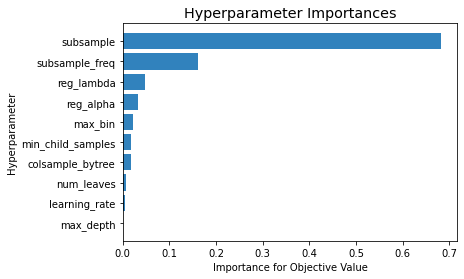

In [9]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

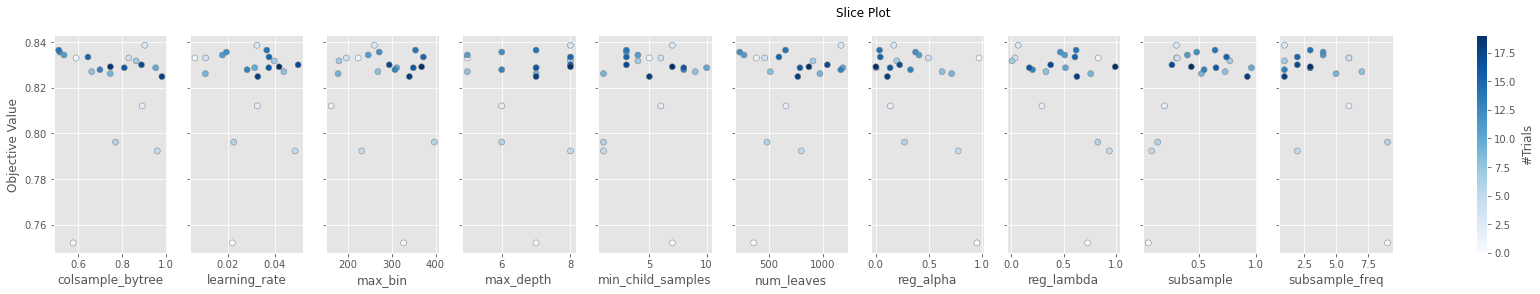

In [10]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### b. Training

In [11]:
lucky_seeds = np.random.randint(0, 1000, num_seed)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros((rows_train, classes))
    pred_test = np.zeros((rows_test, classes), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1)
        
        cv[val_idx,:] = lgbmodel.predict_proba(x_val)
        pred_test += lgbmodel.predict_proba(test_x) / splits_tr
        
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

seed 150 accuracy_score : 0.8312633832976445
seed 857 accuracy_score : 0.8325481798715203
seed 805 accuracy_score : 0.8398286937901499
seed 259 accuracy_score : 0.8436830835117773
seed 522 accuracy_score : 0.8351177730192719
seed 458 accuracy_score : 0.8359743040685225
seed 284 accuracy_score : 0.8355460385438972
seed 642 accuracy_score : 0.8428265524625268
seed 935 accuracy_score : 0.8394004282655246
seed 451 accuracy_score : 0.836830835117773


## (2) XGBoost

In [12]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

### a. Hyperparameter Tuning

In [13]:
def xgb_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": basic_seed,
        "verbose": None,
        "num_class": classes,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.1), # default=0
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.1), # default=1
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # default=0
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.5, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0), # default=1,
        "min_child_weight": trial.suggest_uniform("min_child_weight", 1, 5), # default=1
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True) # Cross-validation cv=5
    cv = np.zeros((rows_train, classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
        cv[val_idx, :] = xgbmodel.predict(dvalid)
        
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))
    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [14]:
sampler = TPESampler(seed=basic_seed)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="maximize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=num_trial)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {'objective':'multi:softprob', "num_class": classes, "eval_metric": "mlogloss", "random_state": basic_seed}
xgb_best_hyperparams.update(xgb_base_hyperparams)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-20 01:55:27,322] A new study created in memory with name: xgb_parameter_opt
[I 2022-03-20 01:56:09,899] Trial 0 finished with value: 0.8184154175588865 and parameters: {'learning_rate': 0.021854305348131316, 'reg_alpha': 0.09507143064099162, 'reg_lambda': 0.0731993941811405, 'max_depth': 12, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'subsample': 0.5290418060840998, 'min_child_weight': 4.46470458309974, 'max_bin': 380}. Best is trial 0 with value: 0.8184154175588865.


accuracy_score: 0.8184154175588865


[I 2022-03-20 01:56:36,776] Trial 1 finished with value: 0.8226980728051392 and parameters: {'learning_rate': 0.03686326600082205, 'reg_alpha': 0.0020584494295802446, 'reg_lambda': 0.09699098521619944, 'max_depth': 14, 'colsample_bytree': 0.6061695553391381, 'colsample_bylevel': 0.5909124836035503, 'subsample': 0.5917022549267169, 'min_child_weight': 2.216968971838151, 'max_bin': 357}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8226980728051392


[I 2022-03-20 01:57:26,048] Trial 2 finished with value: 0.8197002141327623 and parameters: {'learning_rate': 0.024437525838895212, 'reg_alpha': 0.029122914019804193, 'reg_lambda': 0.06118528947223795, 'max_depth': 9, 'colsample_bytree': 0.6460723242676091, 'colsample_bylevel': 0.6831809216468459, 'subsample': 0.728034992108518, 'min_child_weight': 4.140703845572054, 'max_bin': 260}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8197002141327623


[I 2022-03-20 01:58:06,537] Trial 3 finished with value: 0.8167023554603854 and parameters: {'learning_rate': 0.028140549728612525, 'reg_alpha': 0.05924145688620425, 'reg_lambda': 0.0046450412719997725, 'max_depth': 12, 'colsample_bytree': 0.5852620618436457, 'colsample_bylevel': 0.5325257964926398, 'subsample': 0.9744427686266666, 'min_child_weight': 4.862528132298237, 'max_bin': 443}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8167023554603854


[I 2022-03-20 01:58:53,662] Trial 4 finished with value: 0.8214132762312634 and parameters: {'learning_rate': 0.018707619612801683, 'reg_alpha': 0.009767211400638388, 'reg_lambda': 0.0684233026512157, 'max_depth': 11, 'colsample_bytree': 0.5610191174223894, 'colsample_bylevel': 0.7475884550556351, 'subsample': 0.5171942605576092, 'min_child_weight': 4.637281608315128, 'max_bin': 277}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8214132762312634


[I 2022-03-20 01:59:40,724] Trial 5 finished with value: 0.8184154175588865 and parameters: {'learning_rate': 0.034813502795929194, 'reg_alpha': 0.031171107608941095, 'reg_lambda': 0.05200680211778108, 'max_depth': 12, 'colsample_bytree': 0.5924272277627636, 'colsample_bylevel': 0.9847923138822793, 'subsample': 0.8875664116805573, 'min_child_weight': 4.757995766256757, 'max_bin': 469}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8184154175588865


[I 2022-03-20 02:00:14,906] Trial 6 finished with value: 0.8205567451820128 and parameters: {'learning_rate': 0.031905499046498836, 'reg_alpha': 0.09218742350231168, 'reg_lambda': 0.00884925020519195, 'max_depth': 9, 'colsample_bytree': 0.522613644455269, 'colsample_bylevel': 0.6626651653816322, 'subsample': 0.6943386448447411, 'min_child_weight': 2.0853961270955836, 'max_bin': 449}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8205567451820128


[I 2022-03-20 02:01:18,304] Trial 7 finished with value: 0.8141327623126339 and parameters: {'learning_rate': 0.02105389970121152, 'reg_alpha': 0.02809345096873808, 'reg_lambda': 0.05426960831582485, 'max_depth': 9, 'colsample_bytree': 0.9010984903770198, 'colsample_bylevel': 0.5372753218398854, 'subsample': 0.9934434683002586, 'min_child_weight': 4.08897907718663, 'max_bin': 259}. Best is trial 1 with value: 0.8226980728051392.


accuracy_score: 0.8141327623126339


[I 2022-03-20 02:05:09,100] Trial 8 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.005248495270562108, 'reg_alpha': 0.08154614284548342, 'reg_lambda': 0.07068573438476171, 'max_depth': 13, 'colsample_bytree': 0.8856351733429728, 'colsample_bylevel': 0.5370223258670452, 'subsample': 0.6792328642721364, 'min_child_weight': 1.4634762381005189, 'max_bin': 459}. Best is trial 8 with value: 0.8244111349036403.


accuracy_score: 0.8244111349036403


[I 2022-03-20 02:05:47,295] Trial 9 finished with value: 0.8197002141327623 and parameters: {'learning_rate': 0.03304841570724011, 'reg_alpha': 0.03308980248526492, 'reg_lambda': 0.006355835028602364, 'max_depth': 10, 'colsample_bytree': 0.6625916610133735, 'colsample_bylevel': 0.864803089169032, 'subsample': 0.8187787356776066, 'min_child_weight': 4.548850970305306, 'max_bin': 342}. Best is trial 8 with value: 0.8244111349036403.


accuracy_score: 0.8197002141327623


[I 2022-03-20 02:09:56,197] Trial 10 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.005925193523760276, 'reg_alpha': 0.070613365195573, 'reg_lambda': 0.030769421145026243, 'max_depth': 15, 'colsample_bytree': 0.9896117410993797, 'colsample_bylevel': 0.8451235367845727, 'subsample': 0.628963476300746, 'min_child_weight': 1.0444575392908453, 'max_bin': 491}. Best is trial 10 with value: 0.8265524625267666.


accuracy_score: 0.8265524625267666


[I 2022-03-20 02:14:28,335] Trial 11 finished with value: 0.8248394004282655 and parameters: {'learning_rate': 0.005305095126273518, 'reg_alpha': 0.07183803821417527, 'reg_lambda': 0.028342213458443802, 'max_depth': 15, 'colsample_bytree': 0.994860182233656, 'colsample_bylevel': 0.8513496163789994, 'subsample': 0.6422284320908204, 'min_child_weight': 1.0441862590198585, 'max_bin': 500}. Best is trial 10 with value: 0.8265524625267666.


accuracy_score: 0.8248394004282655


[I 2022-03-20 02:18:22,569] Trial 12 finished with value: 0.8231263383297645 and parameters: {'learning_rate': 0.005349375919573378, 'reg_alpha': 0.06458564407032412, 'reg_lambda': 0.02875131383976921, 'max_depth': 15, 'colsample_bytree': 0.9985702612822334, 'colsample_bylevel': 0.8588729908849949, 'subsample': 0.6114239841499921, 'min_child_weight': 1.1343435397378894, 'max_bin': 498}. Best is trial 10 with value: 0.8265524625267666.


accuracy_score: 0.8231263383297645


[I 2022-03-20 02:18:49,533] Trial 13 finished with value: 0.8291220556745182 and parameters: {'learning_rate': 0.049820743928634594, 'reg_alpha': 0.06648719983673654, 'reg_lambda': 0.03170466499757317, 'max_depth': 15, 'colsample_bytree': 0.9928026005220635, 'colsample_bylevel': 0.8585787245031459, 'subsample': 0.62077746649017, 'min_child_weight': 2.98834157444341, 'max_bin': 406}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8291220556745182


[I 2022-03-20 02:19:19,581] Trial 14 finished with value: 0.8214132762312634 and parameters: {'learning_rate': 0.04891214234253278, 'reg_alpha': 0.051287671496938456, 'reg_lambda': 0.03666275225664733, 'max_depth': 14, 'colsample_bytree': 0.8173706947302694, 'colsample_bylevel': 0.9501945220447685, 'subsample': 0.7793992915216573, 'min_child_weight': 3.3105174299610494, 'max_bin': 400}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8214132762312634


[I 2022-03-20 02:19:42,615] Trial 15 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.04833897948373926, 'reg_alpha': 0.07866278717699987, 'reg_lambda': 0.03895222785183715, 'max_depth': 14, 'colsample_bytree': 0.9288586367613886, 'colsample_bylevel': 0.796723937376033, 'subsample': 0.5716575049775884, 'min_child_weight': 3.068340959124283, 'max_bin': 418}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.823982869379015


[I 2022-03-20 02:20:11,704] Trial 16 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.042508344816414384, 'reg_alpha': 0.04402019248592142, 'reg_lambda': 0.01850573473958037, 'max_depth': 15, 'colsample_bytree': 0.7812564285126709, 'colsample_bylevel': 0.9171076241918301, 'subsample': 0.6548503898583582, 'min_child_weight': 2.4640875368890534, 'max_bin': 203}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8265524625267666


[I 2022-03-20 02:20:45,471] Trial 17 finished with value: 0.8235546038543897 and parameters: {'learning_rate': 0.042140626470098586, 'reg_alpha': 0.04369953380785134, 'reg_lambda': 0.016079549240868934, 'max_depth': 13, 'colsample_bytree': 0.7537458820696783, 'colsample_bylevel': 0.9295213686337261, 'subsample': 0.7982208350915346, 'min_child_weight': 2.55315013552509, 'max_bin': 209}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8235546038543897


[I 2022-03-20 02:21:54,385] Trial 18 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.014206638367161342, 'reg_alpha': 0.08233469277140423, 'reg_lambda': 0.04333290071887191, 'max_depth': 13, 'colsample_bytree': 0.8475574676515811, 'colsample_bylevel': 0.7957588354978627, 'subsample': 0.5599442384907506, 'min_child_weight': 3.5512416663951134, 'max_bin': 320}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8244111349036403


[I 2022-03-20 02:22:22,473] Trial 19 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.0431537827666532, 'reg_alpha': 0.0460789976564514, 'reg_lambda': 0.02013636209228828, 'max_depth': 8, 'colsample_bytree': 0.7657843665388768, 'colsample_bylevel': 0.9024477874108626, 'subsample': 0.678334865035663, 'min_child_weight': 2.635143752500486, 'max_bin': 213}. Best is trial 13 with value: 0.8291220556745182.


accuracy_score: 0.8265524625267666
The best hyperparameters are:
 {'learning_rate': 0.049820743928634594, 'reg_alpha': 0.06648719983673654, 'reg_lambda': 0.03170466499757317, 'max_depth': 15, 'colsample_bytree': 0.9928026005220635, 'colsample_bylevel': 0.8585787245031459, 'subsample': 0.62077746649017, 'min_child_weight': 2.98834157444341, 'max_bin': 406, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 42}


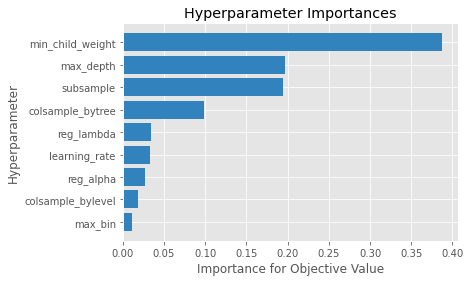

In [15]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

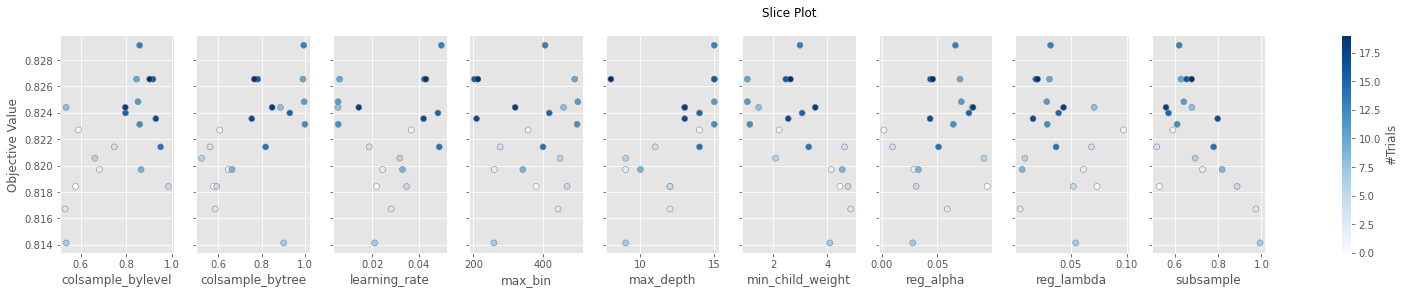

In [16]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [17]:
lucky_seeds = np.random.randint(0, 1000, num_seed)
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((rows_train, classes))
    pred_test = np.zeros((rows_test, classes), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = xgbmodel.predict(dvalid)
        pred_test += xgbmodel.predict(xgtest) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

seed 526 accuracy_score : 0.828693790149893
seed 725 accuracy_score : 0.8312633832976445
seed 307 accuracy_score : 0.8201284796573876
seed 579 accuracy_score : 0.8329764453961456
seed 233 accuracy_score : 0.828693790149893
seed 429 accuracy_score : 0.8299785867237688
seed 115 accuracy_score : 0.8346895074946467
seed 677 accuracy_score : 0.8351177730192719
seed 913 accuracy_score : 0.8291220556745182
seed 810 accuracy_score : 0.8282655246252677


## (3) CNN

In [18]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

### a. Hyperparameter Tuning

In [19]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(classes, activation='softmax'))
    
    return model

In [20]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state = basic_seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((rows_train, classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"../model/model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"../model/model_{n+1}.h5")
        cv[val_idx, :] = best.predict(x_val)
        
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))
    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [21]:
sampler = TPESampler(seed=basic_seed)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=num_trial)
cnn_best_hyperparams = cnn_study.best_trial.params
print("The best hyperparameters are:\n", cnn_best_hyperparams)

[I 2022-03-20 02:39:12,935] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-20 02:40:03,688] Trial 0 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.867237687366167.


accuracy_score: 0.867237687366167


[I 2022-03-20 02:40:59,620] Trial 1 finished with value: 0.8723768736616703 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 1 with value: 0.8723768736616703.


accuracy_score: 0.8723768736616703


[I 2022-03-20 02:41:47,140] Trial 2 finished with value: 0.8693790149892934 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 1 with value: 0.8723768736616703.


accuracy_score: 0.8693790149892934


[I 2022-03-20 02:42:45,720] Trial 3 finished with value: 0.880085653104925 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.880085653104925


[I 2022-03-20 02:43:34,735] Trial 4 finished with value: 0.8633832976445396 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8633832976445396


[I 2022-03-20 02:44:13,767] Trial 5 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8680942184154176


[I 2022-03-20 02:45:53,961] Trial 6 finished with value: 0.8676659528907923 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8676659528907923


[I 2022-03-20 02:46:59,158] Trial 7 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8710920770877945


[I 2022-03-20 02:47:59,621] Trial 8 finished with value: 0.8655246252676659 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8655246252676659


[I 2022-03-20 02:48:40,660] Trial 9 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8685224839400428


[I 2022-03-20 02:49:44,323] Trial 10 finished with value: 0.8633832976445396 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 16.0, 'num_filter_1': 224.0, 'num_filter_2': 256.0, 'learning_rate': 0.0022113183211331486}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8633832976445396


[I 2022-03-20 02:50:49,362] Trial 11 finished with value: 0.8740899357601714 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 96.0, 'num_filter_1': 176.0, 'num_filter_2': 16.0, 'learning_rate': 0.002209611899878945}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8740899357601714


[I 2022-03-20 02:51:50,980] Trial 12 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 96.0, 'num_filter_1': 192.0, 'num_filter_2': 16.0, 'learning_rate': 0.0021686201328808257}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8706638115631692


[I 2022-03-20 02:52:42,555] Trial 13 finished with value: 0.8728051391862955 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 96.0, 'num_filter_1': 128.0, 'num_filter_2': 16.0, 'learning_rate': 0.0021466060390753186}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8728051391862955


[I 2022-03-20 02:53:56,123] Trial 14 finished with value: 0.8663811563169165 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 48.0, 'num_filter_1': 192.0, 'num_filter_2': 144.0, 'learning_rate': 0.0005237504175193482}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8663811563169165


[I 2022-03-20 02:55:05,362] Trial 15 finished with value: 0.8723768736616703 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 128.0, 'num_filter_1': 112.0, 'num_filter_2': 96.0, 'learning_rate': 0.002672758559143003}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8723768736616703


[I 2022-03-20 02:56:05,389] Trial 16 finished with value: 0.8676659528907923 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 128.0, 'num_filter_1': 160.0, 'num_filter_2': 80.0, 'learning_rate': 0.001759799235582663}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8676659528907923


[I 2022-03-20 02:57:25,484] Trial 17 finished with value: 0.8646680942184154 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 64.0, 'num_filter_1': 192.0, 'num_filter_2': 208.0, 'learning_rate': 0.0025883086450706693}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8646680942184154


[I 2022-03-20 02:58:38,596] Trial 18 finished with value: 0.8715203426124197 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 112.0, 'num_filter_1': 224.0, 'num_filter_2': 64.0, 'learning_rate': 0.0016274386132754596}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8715203426124197


[I 2022-03-20 02:59:08,484] Trial 19 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 50.0, 'num_filter_0': 16.0, 'num_filter_1': 32.0, 'learning_rate': 0.0030313078566140375}. Best is trial 3 with value: 0.880085653104925.


accuracy_score: 0.8710920770877945
The best hyperparameters are:
 {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}


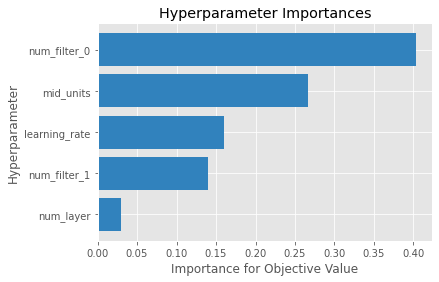

In [22]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

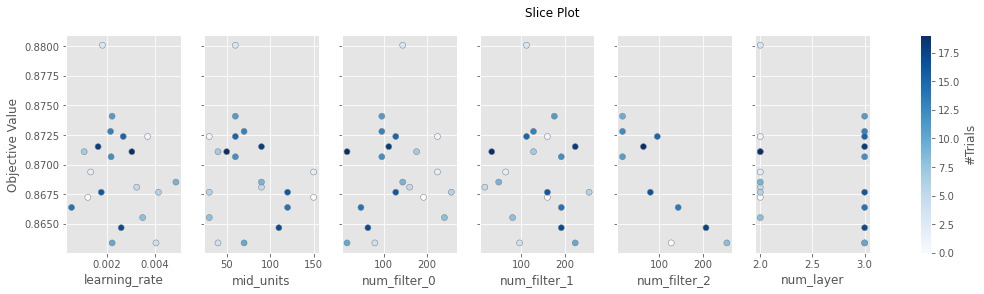

In [23]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

### b. Training

In [24]:
lucky_seeds = np.random.randint(0, 1000, num_seed)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv=np.zeros((rows_train, classes))
    pred_test = np.zeros((rows_test, classes), dtype=float)
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    
    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):
        
        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                  [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])

        # ModelCheckpoint Fold마다 갱신
        mc = ModelCheckpoint(f"../model/model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)

        # 모델 Complie
        optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
        cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
        cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                callbacks=[es,mc], verbose=0)

        # 최고 성능 기록 모델
        best = load_model(f"../model/model_{i+1}.h5")
        cv[val_idx,:] = best.predict(x_val)
        pred_test += best.predict(test_x) / splits_tr
        
    pred_dict['cnn'+str(seed)] = cv
    pred_test_dict['cnn'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

seed 232 accuracy_score : 0.8796573875802998
seed 432 accuracy_score : 0.8830835117773019
seed 103 accuracy_score : 0.880085653104925
seed 299 accuracy_score : 0.8830835117773019
seed 424 accuracy_score : 0.884796573875803
seed 110 accuracy_score : 0.8826552462526767
seed 451 accuracy_score : 0.8758029978586723
seed 916 accuracy_score : 0.8740899357601714
seed 263 accuracy_score : 0.8826552462526767
seed 175 accuracy_score : 0.8822269807280514


## (4) CNN (Rectangular)

<img src = https://www.researchgate.net/profile/Jamil-Ahmad-13/publication/320737885/figure/fig2/AS:941749673414722@1601542027738/Proposed-CNN-architecture-with-rectangular-kernels.gif>

In [26]:
train_X = train.drop(['target', 'id'], axis = 1)
train_X = (train_X+130)/260 
train_X = np.array(train_X)
train_X = np.array(train_X).reshape(-1, 8, 4, 1)

train_Y = train['target']
train_Y = np.array(train_Y)

X_test = test.drop('id', axis = 1)
X_test = (X_test+130)/260
X_test = np.array(X_test).reshape(-1, 8, 4, 1)

In [27]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = Conv2D(filters, (1,1), padding='SAME')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters, kernel_size, padding='SAME')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = BatchNormalization()(X)
    
    # Add
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [28]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = Conv2D(filters, (1,1), padding='SAME')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters, kernel_size, padding='SAME')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = BatchNormalization()(X_shortcut)
    
    # Add
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [29]:
def CustomModel(input_shape = (8, 4, 1), classes = 4):
    X_input = Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2)) #(3,3) 보다는 직사각형 이미지이기때문에 (3,2)처럼 직사각형 필터를 사용
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = AveragePooling2D(2,2)(X) #Max보다는 Average pool이 성능이 잘나옴

    X = convolutional_block(X, 256, (2,1)) #(2,1) 직사각형 필터를 사용
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = GlobalAveragePooling2D()(X) #Flatten 대신 사용
    
    X = Dense(128, activation = "relu")(X)
    
    X = Dropout(0.5)(X)
    
    X = Dense(classes, activation = "softmax")(X)

    model = Model(inputs = X_input, outputs = X, name = "CustomModel")
    
    return model

In [ ]:
lucky_seeds = np.random.randint(1, 1000, num_seed)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기 #총 15번의 fold 진행
    cv = np.zeros((rows_train, classes))
    pred_test = np.zeros((rows_test, classes), dtype=float)

    for train_index, valid_index in kfold.split(train_X, train_Y):
        
        X_train, X_valid = train_X[train_index], train_X[valid_index]
        y_train, y_valid = train_Y[train_index], train_Y[valid_index]

        ### Swap Noise ###
        X_train_mix = np.array(X_train)
        for x in range(X_train_mix.shape[0]):
            for i in range(5):
                y = np.random.randint(0, 8)
                z = np.random.randint(0, 4)

                while True:
                    c = np.random.randint(0, X_train_mix.shape[0]-1)
                    if ((x != c)and(y_train[x] == y_train[c])):
                        break

                X_train_mix[x][y][z] = X_train[c][y][z]

        X_train = np.append(X_train, X_train_mix, axis = 0)
        y_train = np.append(y_train, y_train, axis = 0)

        ### Mix Data Again ####
        X_train, y_train = shuffle(X_train, y_train, random_state=basic_seed)

        y_train = tf.one_hot(y_train, classes)
        y_train = tf.reshape(y_train, [-1,classes])
        y_train = np.array(y_train)

        y_valid = tf.one_hot(y_valid, classes)
        y_valid = tf.reshape(y_valid, [-1,classes])
        y_valid = np.array(y_valid)

        ### Create Model ###
        model = CustomModel()

        ### Compile Model ###
        model.compile(optimizer='adam', # 무난한 adam 사용
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        ### Create callbacks ###
        filename = '../model/CNN-checkpoint.h5'
        checkpoint = ModelCheckpoint(filename, # file명을 지정합니다
                                     monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
                                     verbose=0, # 로그를 출력합니다 0일경우 출력 X
                                     save_best_only=True, # 가장 best 값만 저장합니다
                                     mode='auto' # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                    )
        earlystopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                      patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                     )
        reduceLR = ReduceLROnPlateau(
            monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
            factor=0.5, # learning rate이 0.5배 줄어듬
            patience=6, # 6 Epoch동안 개선되지 않는다면 호출
        )

        ### fit model ###
        data = model.fit(X_train, 
                         y_train, 
                         validation_data=(X_valid, y_valid), 
                         epochs=60, 
                         batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                         callbacks=[reduceLR, earlystopping, checkpoint],
                         verbose=0 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                        )

        idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))

#         print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
#                                                                     data.history['val_accuracy'][idx], 
#                                                                     data.history['val_loss'][idx]))

        ### predict model ###
        model = load_model('../model/CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴

        cv[valid_index,:] = model.predict(X_valid)
        pred_test += model.predict(X_test) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함

    pred_dict['rcnn'+ str(seed)] = cv
    pred_test_dict['rcnn'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_Y, np.argmax(cv, axis=1)))

In [37]:
lucky_seeds = np.random.randint(1, 1000, num_seed)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기 #총 15번의 fold 진행
    cv = np.zeros((rows_train, classes))
    pred_test = np.zeros((rows_test, classes), dtype=float)

    for train_index, valid_index in kfold.split(train_X, train_Y):
        
        X_train, X_valid = train_X[train_index], train_X[valid_index]
        y_train, y_valid = train_Y[train_index], train_Y[valid_index]

        ### Swap Noise ###
        X_train_mix = np.array(X_train)
        for x in range(X_train_mix.shape[0]):
            for i in range(5):
                y = np.random.randint(0, 8)
                z = np.random.randint(0, 4)

                while True:
                    c = np.random.randint(0, X_train_mix.shape[0]-1)
                    if ((x != c)and(y_train[x] == y_train[c])):
                        break

                X_train_mix[x][y][z] = X_train[c][y][z]

        X_train = np.append(X_train, X_train_mix, axis = 0)
        y_train = np.append(y_train, y_train, axis = 0)

        ### Mix Data Again ####
        X_train, y_train = shuffle(X_train, y_train, random_state=basic_seed)

        y_train = tf.one_hot(y_train, classes)
        y_train = tf.reshape(y_train, [-1,classes])
        y_train = np.array(y_train)

        y_valid = tf.one_hot(y_valid, classes)
        y_valid = tf.reshape(y_valid, [-1,classes])
        y_valid = np.array(y_valid)

        ### Create Model ###
        model = CustomModel()

        ### Compile Model ###
        model.compile(optimizer='adam', # 무난한 adam 사용
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        ### Create callbacks ###
        filename = '../model/CNN-checkpoint.h5'
        checkpoint = ModelCheckpoint(filename, # file명을 지정합니다
                                     monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
                                     verbose=0, # 로그를 출력합니다 0일경우 출력 X
                                     save_best_only=True, # 가장 best 값만 저장합니다
                                     mode='auto' # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                    )
        earlystopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                      patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                     )
        reduceLR = ReduceLROnPlateau(
            monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
            factor=0.5, # learning rate이 0.5배 줄어듬
            patience=6, # 6 Epoch동안 개선되지 않는다면 호출
        )

        ### fit model ###
        data = model.fit(X_train, 
                         y_train, 
                         validation_data=(X_valid, y_valid), 
                         epochs=60, 
                         batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                         callbacks=[reduceLR, earlystopping, checkpoint],
                         verbose=0 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                        )

        idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))

#         print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
#                                                                     data.history['val_accuracy'][idx], 
#                                                                     data.history['val_loss'][idx]))

        ### predict model ###
        model = load_model('../model/CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴

        cv[valid_index,:] = model.predict(X_valid)
        pred_test += model.predict(X_test) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함

    pred_dict['rcnn'+ str(seed)] = cv
    pred_test_dict['rcnn'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_Y, np.argmax(cv, axis=1)))

seed 196 accuracy_score : 0.8805139186295503
seed 173 accuracy_score : 0.8766595289079229
seed 976 accuracy_score : 0.8813704496788008


# 3. Stacking (XGB)

## (1) Collect Data

In [39]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:accuracy_score(np.argmax(train_y, axis=1), 
                                    np.argmax(list(x[1]), axis=1)), reverse=True)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [40]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)
pred_dict_cnn, pred_test_dict_cnn = sort_dict('cnn', pred_dict, pred_test_dict)
pred_dict_rcnn, pred_test_dict_rcnn = sort_dict('rcnn', pred_dict, pred_test_dict)

In [42]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pkl/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pkl/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [43]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)
save_dict('cnn', pred_dict_cnn, pred_test_dict_cnn)
save_dict('rcnn', pred_dict_rcnn, pred_test_dict_rcnn)

In [44]:
def load_dict(model):
    with open('../pkl/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)
    with open('../pkl/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)    
    return pred_dict_new_local, pred_test_dict_new_local

In [45]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')
pred_dict_cnn, pred_test_dict_cnn = load_dict('cnn')
pred_dict_rcnn, pred_test_dict_rcnn = load_dict('rcnn')

In [46]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb, **pred_dict_cnn, **pred_dict_rcnn}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb, **pred_test_dict_cnn, **pred_test_dict_rcnn}

## (2) HP Tuning

In [47]:
train_y = train.iloc[:, -1:]

In [48]:
def stack_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": basic_seed,
        "verbose": None,
        "num_class": classes,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.1, 1.0),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "gamma": trial.suggest_uniform("gamma", 0.0, 0.5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 100, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True)
    cv = np.zeros((rows_train, classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
        cv[val_idx, :] = stack_xgbmodel.predict(dvalid)

    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [49]:
X_train = pd.DataFrame(np.hstack([x for _, x in pred_dict_total.items()]))
X_test = pd.DataFrame(np.hstack([x for _, x in pred_test_dict_total.items()]))

sampler = TPESampler(seed=basic_seed)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="maximize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=num_trial)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {'objective':'multi:softprob', "num_class": classes, "eval_metric": "mlogloss", "random_state": basic_seed}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

[I 2022-03-20 23:09:15,433] A new study created in memory with name: stack_parameter_opt
[I 2022-03-20 23:09:29,834] Trial 0 finished with value: 0.8980728051391863 and parameters: {'learning_rate': 0.019039735882944445, 'reg_alpha': 0.9556428757689246, 'reg_lambda': 0.7587945476302645, 'max_depth': 8, 'colsample_bytree': 0.40921304830970556, 'colsample_bylevel': 0.40919616423534183, 'subsample': 0.5290418060840998, 'gamma': 0.4330880728874676, 'min_child_weight': 7, 'max_bin': 313}. Best is trial 0 with value: 0.8980728051391863.


accuracy_score: 0.8980728051391863


[I 2022-03-20 23:12:14,489] Trial 1 finished with value: 0.9006423982869379 and parameters: {'learning_rate': 0.0015189324676422211, 'reg_alpha': 0.9729188669457949, 'reg_lambda': 0.8491983767203796, 'max_depth': 7, 'colsample_bytree': 0.42727747704497043, 'colsample_bylevel': 0.4283831568974037, 'subsample': 0.6521211214797689, 'gamma': 0.2623782158161189, 'min_child_weight': 5, 'max_bin': 187}. Best is trial 1 with value: 0.9006423982869379.


accuracy_score: 0.9006423982869379


[I 2022-03-20 23:12:26,730] Trial 2 finished with value: 0.9027837259100643 and parameters: {'learning_rate': 0.030786718288757786, 'reg_alpha': 0.22554447458683766, 'reg_lambda': 0.3629301836816964, 'max_depth': 7, 'colsample_bytree': 0.619248988951925, 'colsample_bylevel': 0.8496231729751094, 'subsample': 0.5998368910791798, 'gamma': 0.2571172192068058, 'min_child_weight': 6, 'max_bin': 113}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9027837259100643


[I 2022-03-20 23:12:45,456] Trial 3 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.0305734701691212, 'reg_alpha': 0.2534717113185624, 'reg_lambda': 0.1585464336867516, 'max_depth': 10, 'colsample_bytree': 0.9759424231521916, 'colsample_bylevel': 0.8658781436815228, 'subsample': 0.6523068845866853, 'gamma': 0.048836057003191935, 'min_child_weight': 7, 'max_bin': 232}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:13:30,257] Trial 4 finished with value: 0.8989293361884368 and parameters: {'learning_rate': 0.006540892624816552, 'reg_alpha': 0.5456592191001431, 'reg_lambda': 0.13094966900369656, 'max_depth': 10, 'colsample_bytree': 0.48114598712001183, 'colsample_bylevel': 0.7637655990477874, 'subsample': 0.6558555380447055, 'gamma': 0.2600340105889054, 'min_child_weight': 6, 'max_bin': 155}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8989293361884368


[I 2022-03-20 23:13:41,950] Trial 5 finished with value: 0.8993576017130621 and parameters: {'learning_rate': 0.04849443907434565, 'reg_alpha': 0.7976195410250031, 'reg_lambda': 0.9455490474077702, 'max_depth': 10, 'colsample_bytree': 0.7185299851677596, 'colsample_bylevel': 0.9453119645161818, 'subsample': 0.5442462510259598, 'gamma': 0.0979914312095726, 'min_child_weight': 1, 'max_bin': 197}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8993576017130621


[I 2022-03-20 23:13:59,362] Trial 6 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.01973952583962936, 'reg_alpha': 0.34421412859650635, 'reg_lambda': 0.8458637582367364, 'max_depth': 7, 'colsample_bytree': 0.49665415678116653, 'colsample_bylevel': 0.6798872582107739, 'subsample': 0.5704621124873813, 'gamma': 0.40109849037701983, 'min_child_weight': 1, 'max_bin': 397}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:14:14,137] Trial 7 finished with value: 0.8993576017130621 and parameters: {'learning_rate': 0.038726116080184544, 'reg_alpha': 0.2788441133807552, 'reg_lambda': 0.10496990541124217, 'max_depth': 10, 'colsample_bytree': 0.7948001406933319, 'colsample_bylevel': 0.810305017628691, 'subsample': 0.8856351733429728, 'gamma': 0.03702232586704518, 'min_child_weight': 4, 'max_bin': 134}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8993576017130621


[I 2022-03-20 23:14:22,723] Trial 8 finished with value: 0.8989293361884368 and parameters: {'learning_rate': 0.04322361958084188, 'reg_alpha': 0.6609683141448022, 'reg_lambda': 0.39780822236738433, 'max_depth': 6, 'colsample_bytree': 0.5176876252009635, 'colsample_bylevel': 0.5276283254187228, 'subsample': 0.864803089169032, 'gamma': 0.31877873567760656, 'min_child_weight': 9, 'max_bin': 242}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8989293361884368


[I 2022-03-20 23:15:39,935] Trial 9 finished with value: 0.9019271948608137 and parameters: {'learning_rate': 0.006419915173945934, 'reg_alpha': 0.7419203085006955, 'reg_lambda': 0.7847065437552077, 'max_depth': 8, 'colsample_bytree': 0.8396770259681927, 'colsample_bylevel': 0.6456569174550735, 'subsample': 0.7613664146909971, 'gamma': 0.21377050917927481, 'min_child_weight': 1, 'max_bin': 132}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9019271948608137


[I 2022-03-20 23:15:56,597] Trial 10 finished with value: 0.8997858672376874 and parameters: {'learning_rate': 0.029648234821230794, 'reg_alpha': 0.10539746466023536, 'reg_lambda': 0.4869794786543796, 'max_depth': 6, 'colsample_bytree': 0.6254923439304388, 'colsample_bylevel': 0.9353653566977627, 'subsample': 0.9798853729727101, 'gamma': 0.1626799989856424, 'min_child_weight': 10, 'max_bin': 103}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8997858672376874


[I 2022-03-20 23:16:26,786] Trial 11 finished with value: 0.8989293361884368 and parameters: {'learning_rate': 0.014390198103545667, 'reg_alpha': 0.49595428407545405, 'reg_lambda': 0.6352120297076758, 'max_depth': 8, 'colsample_bytree': 0.8809026798577525, 'colsample_bylevel': 0.605189659599489, 'subsample': 0.7654511711886779, 'gamma': 0.15871619788398433, 'min_child_weight': 3, 'max_bin': 102}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8989293361884368


[I 2022-03-20 23:16:39,057] Trial 12 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.035527023223040285, 'reg_alpha': 0.720582941008578, 'reg_lambda': 0.3155764873519795, 'max_depth': 7, 'colsample_bytree': 0.6748461613037909, 'colsample_bylevel': 0.6917294217246026, 'subsample': 0.7585006738258345, 'gamma': 0.33693207447025114, 'min_child_weight': 3, 'max_bin': 300}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:17:10,890] Trial 13 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.01068581030194337, 'reg_alpha': 0.46011226387517273, 'reg_lambda': 0.6249044385696946, 'max_depth': 9, 'colsample_bytree': 0.8132482076461334, 'colsample_bylevel': 0.5898655473130154, 'subsample': 0.7221019372296134, 'gamma': 0.18154885472521815, 'min_child_weight': 8, 'max_bin': 158}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:17:27,488] Trial 14 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.026520260351677857, 'reg_alpha': 0.8078372586427719, 'reg_lambda': 0.37634013670405986, 'max_depth': 9, 'colsample_bytree': 0.6126062466358484, 'colsample_bylevel': 0.7613200233662818, 'subsample': 0.8308851073086485, 'gamma': 0.484634926024359, 'min_child_weight': 5, 'max_bin': 203}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:17:43,201] Trial 15 finished with value: 0.9002141327623127 and parameters: {'learning_rate': 0.018899619614124084, 'reg_alpha': 0.6486775305145897, 'reg_lambda': 0.5276574987985554, 'max_depth': 8, 'colsample_bytree': 0.3033180837571625, 'colsample_bylevel': 0.3146394965383828, 'subsample': 0.6973068496577353, 'gamma': 0.21773432516589467, 'min_child_weight': 3, 'max_bin': 133}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9002141327623127


[I 2022-03-20 23:29:42,567] Trial 16 finished with value: 0.9010706638115632 and parameters: {'learning_rate': 0.0005447912055875003, 'reg_alpha': 0.12449712375207722, 'reg_lambda': 0.699882075376947, 'max_depth': 7, 'colsample_bytree': 0.9326490218482688, 'colsample_bylevel': 0.8456102692429004, 'subsample': 0.6008964335081206, 'gamma': 0.31564524996793597, 'min_child_weight': 2, 'max_bin': 288}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.9010706638115632


[I 2022-03-20 23:29:58,649] Trial 17 finished with value: 0.8993576017130621 and parameters: {'learning_rate': 0.024595502567303612, 'reg_alpha': 0.3689465013743736, 'reg_lambda': 0.9979816219316286, 'max_depth': 9, 'colsample_bytree': 0.7882483174416645, 'colsample_bylevel': 0.5284013779339728, 'subsample': 0.8020792747505997, 'gamma': 0.08523063926605651, 'min_child_weight': 6, 'max_bin': 345}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8993576017130621


[I 2022-03-20 23:30:15,228] Trial 18 finished with value: 0.8993576017130621 and parameters: {'learning_rate': 0.03545188725000634, 'reg_alpha': 0.8505098538724472, 'reg_lambda': 0.2563613955054954, 'max_depth': 6, 'colsample_bytree': 0.713407244860132, 'colsample_bylevel': 0.9735596793431819, 'subsample': 0.9472206511116316, 'gamma': 0.3687594895043082, 'min_child_weight': 4, 'max_bin': 172}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8993576017130621


[I 2022-03-20 23:30:55,844] Trial 19 finished with value: 0.8997858672376874 and parameters: {'learning_rate': 0.007158303163739986, 'reg_alpha': 0.6332253543455304, 'reg_lambda': 0.43650099761494937, 'max_depth': 7, 'colsample_bytree': 0.5829181279653137, 'colsample_bylevel': 0.7478898003867216, 'subsample': 0.6141487027805386, 'gamma': 0.21631602298675215, 'min_child_weight': 8, 'max_bin': 132}. Best is trial 2 with value: 0.9027837259100643.


accuracy_score: 0.8997858672376874
The best hyperparameters are:
 {'learning_rate': 0.030786718288757786, 'reg_alpha': 0.22554447458683766, 'reg_lambda': 0.3629301836816964, 'max_depth': 7, 'colsample_bytree': 0.619248988951925, 'colsample_bylevel': 0.8496231729751094, 'subsample': 0.5998368910791798, 'gamma': 0.2571172192068058, 'min_child_weight': 6, 'max_bin': 113, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 42}


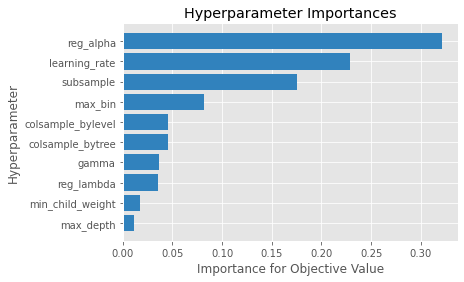

In [50]:
optuna.visualization.matplotlib.plot_param_importances(stack_study);

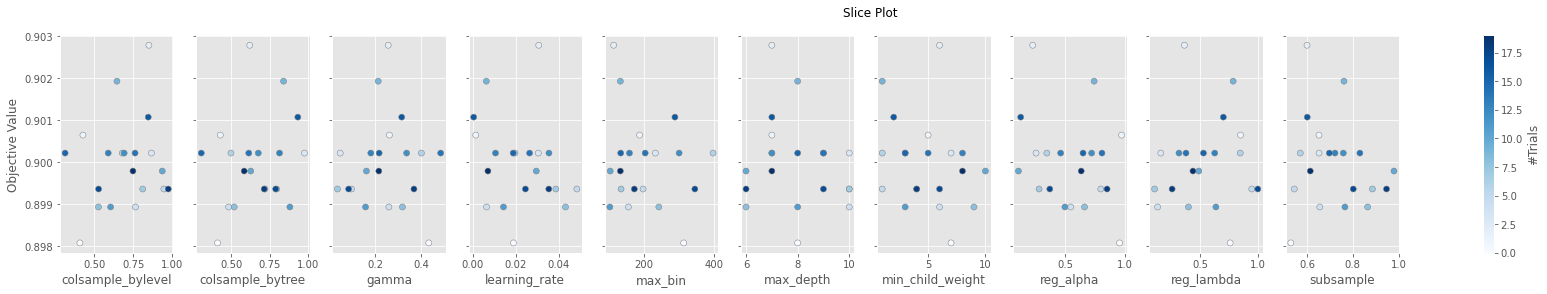

In [51]:
optuna.visualization.matplotlib.plot_slice(stack_study);

## (3) Training

In [52]:
pred = np.zeros((rows_train, classes), dtype=float)
pred_test = np.zeros((rows_test, classes), dtype=float)
kfold = StratifiedKFold(n_splits=splits_tr, random_state=basic_seed, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx, :] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / splits_tr

In [53]:
print(f'CV Log Loss: {log_loss(train_y, pred):.6f}')
print(f'CV Accuracy Score: {accuracy_score(train_y, np.argmax(pred, axis=1)):.6f}')

CV Log Loss: 0.305540
CV Accuracy Score: 0.899358


## 4. Blending

In [54]:
stack_train = pred.copy()
stack_test = pred_test.copy()

In [58]:
candidate = np.arange(0, 11)
permute = permutations(candidate,5)
score = {}
for i in list(permute):
    pred_final = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
              sum(pred_dict_xgb.values())/sel_seed * i[1] +
              sum(pred_dict_cnn.values())/sel_seed * i[2] +
              sum(pred_dict_rcnn.values())/sel_seed * i[3] +
                               stack_train * i[4])
    score[i] = accuracy_score(train_y, np.argmax(pred_final, axis=1))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=True)[:5])
score

{(0, 1, 4, 3, 10): 0.9040685224839401,
 (1, 0, 3, 2, 8): 0.9040685224839401,
 (0, 1, 3, 2, 8): 0.9036402569593148,
 (0, 3, 2, 4, 8): 0.9036402569593148,
 (0, 4, 2, 5, 10): 0.9036402569593148}

In [59]:
pred_final = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
              sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
              sum(pred_dict_cnn.values())/sel_seed * list(score.keys())[0][2] +
              sum(pred_dict_rcnn.values())/sel_seed * list(score.keys())[0][3] +
                               stack_train * list(score.keys())[0][4])
accuracy_score(train_y, np.argmax(pred_final, axis=1))

0.9040685224839401

In [61]:
pred_test_final = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
                   sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
                    sum(pred_test_dict_cnn.values())/3 * list(score.keys())[0][2] +
                    sum(pred_test_dict_rcnn.values())/3 * list(score.keys())[0][3] +
                                          stack_test * list(score.keys())[0][4])

## 5. Submission

In [62]:
submission_name = '20220318'
submission_number = '3'
submission['target'] = np.argmax(pred_test_final, axis=1)
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)
submission.target.value_counts()

1    2443
2    2403
0    2274
3    2223
Name: target, dtype: int64